In [125]:
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
import numpy as np

f = h5py.File('../naslib/data/shd_train.h5', 'r')
f

<HDF5 file "shd_train.h5" (mode r)>

In [126]:
fileh = f
units = fileh.spikes.units
times = fileh.spikes.times
labels = fileh.label

AttributeError: 'File' object has no attribute 'spikes'

In [ ]:
labels, units, times = f['labels'], f['spikes']['units'], f['spikes']['times']
print(list(spikes.keys()))
print(labels, units, times)
index = 0
print("Times (ms):", times[index])
print("Unit IDs:", units[index])
print("Label:", labels[index])

['times', 'units']
<HDF5 dataset "labels": shape (8156,), type "<u2"> <HDF5 dataset "units": shape (8156,), type "|O"> <HDF5 dataset "times": shape (8156,), type "|O">
Times (ms): [0.       0.001833 0.002167 ... 0.698    0.6997   0.7007  ]
Unit IDs: [384 680 465 ...  67  10 260]
Label: 11


In [ ]:
len(set(f['labels']))

20

In [ ]:
class shd(Dataset):

    def __init__(self, root_dir, transform=torch.tensor):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        f = h5py.File(root_dir, 'r')
        self.labels, self.units, self.times = f['labels'], f['spikes']['units'], f['spikes']['times']
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'times': self.times[idx, ], 'units': 700 - self.units[idx, ], 'label': self.labels[idx,]}

        if self.transform:
            sample = {i: self.transform(np.int32(j)) for i, j in sample.items()}

        return sample
    
shd_train_dataset = shd('../naslib/data/shd_train.h5')
shd_test_dataset = shd('../naslib/data/shd_test.h5')

# for j in range(len(shd_train_dataset)):
#     sample = shd_train_dataset[[j, j+10]]

#     print(j, sample['times'], sample['units'], sample['label'])
#     fig = plt.figure(figsize=(16,4))
#     idx = np.random.randint(len(times),size=3)
#     for i,k in enumerate(range(len(sample["times"]))):
#         ax = plt.subplot(1,3,i+1)
#         ax.scatter(sample['times'][i],sample['units'][i], color="k", alpha=0.33, s=2)
#         print(sample['label'])
#         ax.set_title("Label %i"%sample['label'][i])
#         ax.axis("off")
    
#     plt.show()
#     if j == 3:
#         break


In [129]:
from torch.utils import data
import numpy as onp 

import os
import urllib.request
import gzip, shutil
import hashlib
import h5py
from six.moves.urllib.error import HTTPError 
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve

class SpikingNumpyDataset(data.Dataset):
    ''' Numpy based generator
    '''
    def __init__(self, spikes, labels, name, target_dim):
        self.nb_steps = 100
        self.nb_units = 700
        self.max_time = 1.4 
        self.spikes = spikes
        self.labels = labels
        self.name = name

        self.firing_times = self.spikes['times']
        self.units_fired  = self.spikes['units']    
        self.num_samples = self.firing_times.shape[0]
        self.time_bins = onp.linspace(0, self.max_time, num=self.nb_steps)

        self.input  = onp.zeros((self.num_samples, self.nb_steps, self.nb_units), dtype=onp.uint8)
        self.output = onp.array(self.labels, dtype=onp.uint8)

        self.load_spikes()
        self.reduce_inp_dimensions(target_dim=target_dim, axis=2)

    def __len__(self):
        return self.num_samples

    def load_spikes(self):
        for idx in range(self.num_samples):
            times = onp.digitize(self.firing_times[idx], self.time_bins)
            units = self.units_fired[idx] 
            self.input[idx, times, units] = 1

    def reduce_inp_dimensions(self, target_dim, axis):
        sample_ind = int(onp.ceil(self.nb_units / target_dim))
        index = [onp.arange(i, 700, sample_ind) for i in range(sample_ind)]
        reshaped = [onp.take(self.input, index[i], axis) for i in range(sample_ind)]
        reshaped = [onp.pad(reshaped[i], [(0,0), (0,0), (0,int(target_dim-reshaped[i].shape[2]))], mode='constant') for i in range(sample_ind)]
        reshaped = onp.concatenate(reshaped, axis=0)
        self.input = reshaped
        self.output = onp.tile(self.output, sample_ind)
        self.num_samples = reshaped.shape[0]

    def __getitem__(self, idx):
        inputs, outputs = self.__data_generation(idx)
        return inputs, outputs

    def __data_generation(self, idx):
        if self.name == 'shd':
            output = self.output[idx]
        if self.name == 'ssc':
            output = self.output[idx] + 20
        return self.input[idx], output

def numpy_collate(batch):
  if isinstance(batch[0], onp.ndarray):
    return onp.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return onp.array(batch)

class SpikingNumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)


def get_audio_dataset(cache_dir, cache_subdir, dataset_name):
    # The remote directory with the data files
    base_url = "https://zenkelab.org/datasets"

    # Retrieve MD5 hashes from remote
    response = urllib.request.urlopen("%s/md5sums.txt"%base_url)
    data = response.read() 
    lines = data.decode('utf-8').split("\n")
    file_hashes = { line.split()[1]:line.split()[0] for line in lines if len(line.split())==2 }

    # Download the Spiking Heidelberg Digits (SHD) dataset
    if dataset_name == 'shd':
        files = [ "shd_train.h5.gz", "shd_test.h5.gz"]
    if dataset_name == 'ssc':
        files = [ "ssc_train.h5.gz", "ssc_test.h5.gz"]
    if dataset_name == 'all':
        files = [ "shd_train.h5.gz", "shd_test.h5.gz", "ssc_train.h5.gz", "ssc_test.h5.gz"]
        
    for fn in files:
        origin = "%s/%s"%(base_url,fn)
        hdf5_file_path = get_and_gunzip(origin, fn, md5hash=file_hashes[fn], cache_dir=cache_dir, cache_subdir=cache_subdir)
        # print("File %s decompressed to:"%(fn))
        print("Available at: %s"%hdf5_file_path)

def get_and_gunzip(origin, filename, md5hash=None, cache_dir=None, cache_subdir=None):
    gz_file_path = get_file(filename, origin, md5_hash=md5hash, cache_dir=cache_dir, cache_subdir=cache_subdir)
    hdf5_file_path = gz_file_path[:-3]
    if not os.path.isfile(hdf5_file_path) or os.path.getctime(gz_file_path) > os.path.getctime(hdf5_file_path):
        print("Decompressing %s"%gz_file_path)
        with gzip.open(gz_file_path, 'r') as f_in, open(hdf5_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return hdf5_file_path

def validate_file(fpath, file_hash, algorithm='auto', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(file_hash) == 64):
        hasher = 'sha256'
    else:
        hasher = 'md5'

    if str(_hash_file(fpath, hasher, chunk_size)) == str(file_hash):
        return True
    else:
        return False

def _hash_file(fpath, algorithm='sha256', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(hash) == 64):
        hasher = hashlib.sha256()
    else:
        hasher = hashlib.md5()

    with open(fpath, 'rb') as fpath_file:
        for chunk in iter(lambda: fpath_file.read(chunk_size), b''):
            hasher.update(chunk)

    return hasher.hexdigest()

def get_file(fname,
             origin,
             md5_hash=None,
             file_hash=None,
             cache_subdir='datasets',
             hash_algorithm='auto',
             extract=False,
             archive_format='auto',
             cache_dir=None):
    if cache_dir is None:
        cache_dir = os.path.join(os.path.expanduser('~'), '.data-cache')
    if md5_hash is not None and file_hash is None:
        file_hash = md5_hash
        hash_algorithm = 'md5'
    datadir_base = os.path.expanduser(cache_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.data-cache')
    datadir = os.path.join(datadir_base, cache_subdir)

    # Create directories if they don't exist
    os.makedirs(cache_dir, exist_ok=True)
    os.makedirs(datadir, exist_ok=True)

    fpath = os.path.join(datadir, fname)

    download = False
    if os.path.exists(fpath):
    # File found; verify integrity if a hash was provided.
        if file_hash is not None:
            if not validate_file(fpath, file_hash, algorithm=hash_algorithm):
                print('A local file was found, but it seems to be '
                      'incomplete or outdated because the ' + hash_algorithm +
                      ' file hash does not match the original value of ' + file_hash +
                      ' so we will re-download the data.')
                download = True
    else:
        download = True

    if download:
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)

    return fpath

def get_numpy_datasets(dataset_name, n_inp):
    cache_dir = os.path.expanduser("~/data")
    cache_subdir = "audiospikes"
    get_audio_dataset(cache_dir, cache_subdir, dataset_name)

    train_ds = []; test_ds = []
    if dataset_name in ['shd', 'all']:
        train_shd_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
        test_shd_file  = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')
        shd_train_ds = SpikingNumpyDataset(train_shd_file['spikes'], train_shd_file['labels'], name='shd', target_dim=n_inp)
        shd_test_ds  = SpikingNumpyDataset(test_shd_file['spikes'], test_shd_file['labels'], name='shd', target_dim=n_inp)
        train_ds.append(shd_train_ds)
        test_ds.append(shd_test_ds)

    if dataset_name  in ['ssc', 'all']:
        train_ssc_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'ssc_train.h5'), 'r')
        test_ssc_file  = h5py.File(os.path.join(cache_dir, cache_subdir, 'ssc_test.h5'), 'r')
        ssc_train_ds = SpikingNumpyDataset(train_ssc_file['spikes'], train_ssc_file['labels'], name='ssc', target_dim=n_inp)
        ssc_test_ds  = SpikingNumpyDataset(test_ssc_file['spikes'], test_ssc_file['labels'], name='ssc', target_dim=n_inp)
        train_ds.append(torch.Tensor(ssc_train_ds))
        test_ds.append(torch.Tensor(ssc_test_ds))

    return train_ds, test_ds


In [130]:
train_ds, test_ds = [i[0] for i in get_numpy_datasets('shd', 70)]


Available at: /Users/mikhaillebedev/data/audiospikes/shd_train.h5
Available at: /Users/mikhaillebedev/data/audiospikes/shd_test.h5


In [132]:
from torch import nn

shd_train_dataloader = SpikingNumpyLoader(train_ds, batch_size=16, shuffle=True, num_workers=0, )
shd_test_dataloader = SpikingNumpyLoader(test_ds, batch_size=16, shuffle=True, num_workers=0, )

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7000, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 20),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (batch_data) in enumerate(dataloader):
        X, y = batch_data
        pred = model(torch.Tensor(X))
        loss = loss_fn(pred, torch.Tensor(y).long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (batch_data) in enumerate(dataloader):
        # Compute prediction and loss
            X, y = batch_data
            y = torch.Tensor(y).long()
            pred = model(torch.Tensor(X))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

model = NeuralNetwork()
learning_rate = 1e-3
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(shd_train_dataloader, model, loss_fn, optimizer)
    test_loop(shd_test_dataloader, model, loss_fn)
print("Done!")

<__main__.dataset_numpy object at 0x117d007c0> <__main__.dataset_numpy object at 0x11d0b8970>
Epoch 1
-------------------------------
loss: 2.979580  [   16/81560]
loss: 2.987506  [ 1616/81560]
loss: 2.999258  [ 3216/81560]
loss: 2.973476  [ 4816/81560]
loss: 2.976280  [ 6416/81560]
loss: 2.971973  [ 8016/81560]
loss: 2.962631  [ 9616/81560]
loss: 2.976011  [11216/81560]
loss: 2.944972  [12816/81560]
loss: 2.943905  [14416/81560]
loss: 2.921709  [16016/81560]
loss: 2.934406  [17616/81560]
loss: 2.928742  [19216/81560]
loss: 2.895887  [20816/81560]
loss: 2.907654  [22416/81560]
loss: 2.874213  [24016/81560]
loss: 2.880199  [25616/81560]
loss: 2.897183  [27216/81560]
loss: 2.855661  [28816/81560]
loss: 2.850381  [30416/81560]
loss: 2.780887  [32016/81560]
loss: 2.688722  [33616/81560]
loss: 2.862552  [35216/81560]
loss: 2.861005  [36816/81560]
loss: 2.780978  [38416/81560]
loss: 2.799712  [40016/81560]
loss: 2.707682  [41616/81560]
loss: 2.751910  [43216/81560]
loss: 2.647166  [44816/815

In [ ]:
print(labels.shape, units.shape, times.shape)

(8156,) (8156,) (8156,)


In [ ]:
units[[552, 553],]

array([array([ 17, 158, 321, ..., 194, 376,   4], dtype=uint16),
       array([ 79, 428, 315, ..., 307, 341, 148], dtype=uint16)],
      dtype=object)

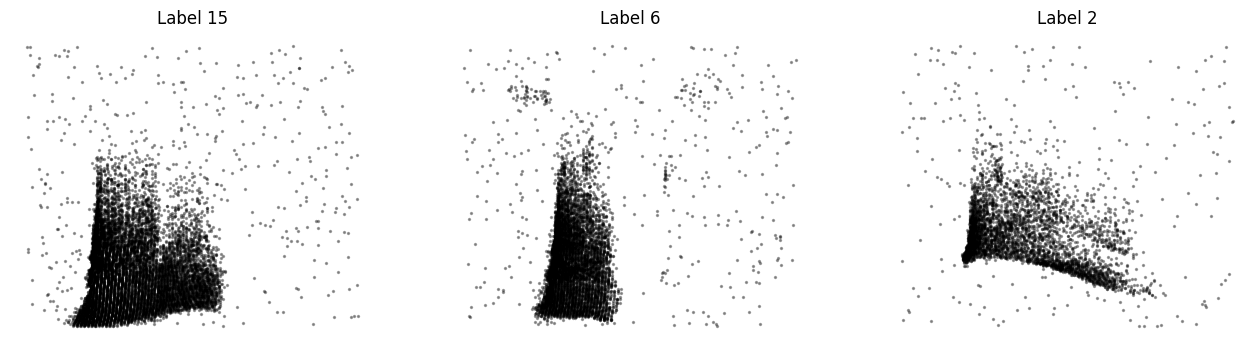

In [ ]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(16,4))
idx = np.random.randint(len(times),size=3)
for i,k in enumerate(idx):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(times[k],700-units[k], color="k", alpha=0.33, s=2)
    ax.set_title("Label %i"%labels[k])
    ax.axis("off")
 
plt.show()